In [4]:
import os
import sys

import numpy as np

pose_path = "pose/"
print(pose_path)
sys.path.append(pose_path)

from scipy.misc import imread, imsave

from config import load_config
from dataset.factory import create as create_dataset
from nnet import predict
from util import visualize
from dataset.pose_dataset import data_to_input

from multiperson.detections import extract_detections
from multiperson.predict import SpatialModel, eval_graph, get_person_conf_multicut
from multiperson.visualize import PersonDraw, visualize_detections

import matplotlib.pyplot as plt


cfg = load_config("pose_cfg_multi.yaml")

dataset = create_dataset(cfg)

sm = SpatialModel(cfg)
sm.load()

draw_multi = PersonDraw()

# Load and setup CNN part detector
sess, inputs, outputs = predict.setup_pose_prediction(cfg)

pose/
Instructions for updating:
Pass is_training directly to the network instead of the arg_scope.


Instructions for updating:
Pass is_training directly to the network instead of the arg_scope.


ValueError: Variable resnet_v1_101/conv1/weights already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/home/lukasz/anaconda2/envs/coco/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 216, in variable
    use_resource=use_resource)
  File "/home/lukasz/anaconda2/envs/coco/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "/home/lukasz/anaconda2/envs/coco/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 261, in model_variable
    use_resource=use_resource)


In [83]:
# Read image from file
file_name = "pixelated_faces.jpg"
image = imread(file_name, mode='RGB')

image_batch = data_to_input(image)

In [84]:
%matplotlib inline  
# Compute prediction with the CNN
outputs_np = sess.run(outputs, feed_dict={inputs: image_batch})
scmap, locref, pairwise_diff = predict.extract_cnn_output(outputs_np, cfg, dataset.pairwise_stats)
detections = extract_detections(cfg, scmap, locref, pairwise_diff)

num_people:  22
#tracked objects: 0


/home/lukasz/anaconda2/envs/coco/lib/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: Mean of empty slice


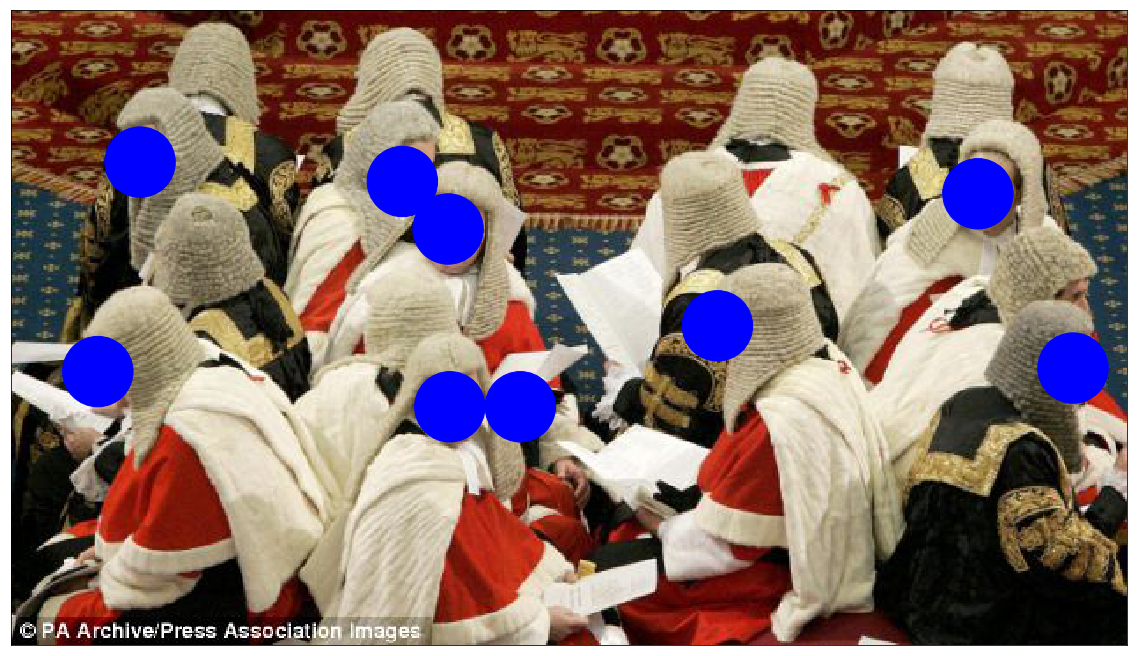

In [88]:
import munkres
import math
import numpy
from util.visualize import check_point, _npcircle
marker_size = 5
draw_conf_min_count = 3

class PersonDraw:
    def __init__(self):
        self.mk = munkres.Munkres()

        self.prev_person_conf = np.zeros([0, 1])
        self.prev_color_assignment = None

        # generated colors from http://tools.medialab.sciences-po.fr/iwanthue/
        track_colors_str = ["#F5591E",
                            "#3870FB",
                            "#FE5DB0",
                            "#B4A691",
                            "#43053F",
                            "#3475B1",
                            "#642612",
                            "#B3B43D",
                            "#DD9BFE",
                            "#28948D",
                            "#E99D53",
                            "#012B46",
                            "#9D2DA3",
                            "#04220A",
                            "#62CB22",
                            "#EE8F91",
                            "#D71638",
                            "#00613A",
                            "#318918",
                            "#B770FF",
                            "#82C091",
                            "#6C1333",
                            "#973405",
                            "#B19CB2",
                            "#F6267B",
                            "#284489",
                            "#97BF17",
                            "#3B899C",
                            "#931813",
                            "#FA76B6"]

        self.track_colors = [(int(s[1:3], 16), int(s[3:5], 16), int(s[5:7], 16)) for s in track_colors_str]

    def draw(self, visim, dataset, person_conf):
        minx = 2 * marker_size
        miny = 2 * marker_size
        maxx = visim.shape[1] - 2 * marker_size
        maxy = visim.shape[0] - 2 * marker_size

        num_people = person_conf.shape[0]
        color_assignment = dict()

        # MA: assign same color to matching body configurations
        if self.prev_person_conf.shape[0] > 0 and person_conf.shape[0] > 0:
            ref_points = get_ref_points(person_conf)
            prev_ref_points = get_ref_points(self.prev_person_conf)

            # MA: this munkres implementation assumes that num(rows) >= num(columns)
            if person_conf.shape[0] <= self.prev_person_conf.shape[0]:
                cost_matrix = scipy.spatial.distance.cdist(ref_points, prev_ref_points)
            else:
                cost_matrix = scipy.spatial.distance.cdist(prev_ref_points, ref_points)

            assert (cost_matrix.shape[0] <= cost_matrix.shape[1])

            conf_assign = self.mk.compute(cost_matrix)

            if person_conf.shape[0] > self.prev_person_conf.shape[0]:
                conf_assign = [(idx2, idx1) for idx1, idx2 in conf_assign]
                cost_matrix = cost_matrix.T

            for pidx1, pidx2 in conf_assign:
                if cost_matrix[pidx1][pidx2] < min_match_dist:
                    color_assignment[pidx1] = self.prev_color_assignment[pidx2]

        print("#tracked objects:", len(color_assignment))

        free_coloridx = sorted(list(set(range(len(self.track_colors))).difference(set(color_assignment.values()))),
                               reverse=True)

        for pidx in range(num_people):
            # color_idx = pidx % len(self.track_colors)
            if pidx in color_assignment:
                color_idx = color_assignment[pidx]
            else:
                if len(free_coloridx) > 0:
                    color_idx = free_coloridx[-1]
                    free_coloridx = free_coloridx[:-1]
                else:
                    color_idx = np.random.randint(len(self.track_colors))

                color_assignment[pidx] = color_idx

            assert (color_idx < len(self.track_colors))

            if np.sum(person_conf[pidx, :, 0] > 0) < draw_conf_min_count:
                continue

            newrow = []
            face_points = numpy.array([]).reshape(0,2)
            
            idx = 0
            for kidx1, kidx2 in dataset.get_pose_segments()[:4]:
                idx += 1
                p1 = (int(math.floor(person_conf[pidx, kidx1, 0])), int(math.floor(person_conf[pidx, kidx1, 1])))
                p2 = (int(math.floor(person_conf[pidx, kidx2, 0])), int(math.floor(person_conf[pidx, kidx2, 1])))

                if check_point(p1[0], p1[1], minx, miny, maxx, maxy) and check_point(p2[0], p2[1], minx, miny, maxx,
                                                                                     maxy):
                    face_points = numpy.vstack([face_points, [p1[0], p1[1]]])
                    if (idx == 4):
                        face_points = numpy.vstack([face_points, [p2[0], p2[1]]])
                    

#            color = np.array(self.track_colors[0][::-1], dtype=np.float64) / 255.0
#            plt.plot([p1[0], p1[0]], [p1[1], p1[1]], marker='o', linestyle='solid', linewidth=2.0, color=color)

            face_center = numpy.nanmean(face_points, axis=0)
            if numpy.isnan(face_center[0]) or numpy.isnan(face_center[1]):
                continue

            circle = plt.Circle((int(face_center[0]),int(face_center[1])), 20, color='blue')
            fig = plt.gcf()
            ax = fig.gca()
            ax.add_artist(circle)

        self.prev_person_conf = person_conf
        self.prev_color_assignment = color_assignment

draw_multi = PersonDraw()

unLab, pos_array, unary_array, pwidx_array, pw_array = eval_graph(sm, detections)
person_conf_multi = get_person_conf_multicut(sm, unLab, unary_array, pos_array)

img = np.copy(image)

visim_multi = img.copy()

plt.figure(figsize = (20,20))
fig = plt.imshow(visim_multi)

draw_multi.draw(visim_multi[:,:,:], dataset, person_conf_multi[:,:,:])
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

plt.show()